# **Functional API**

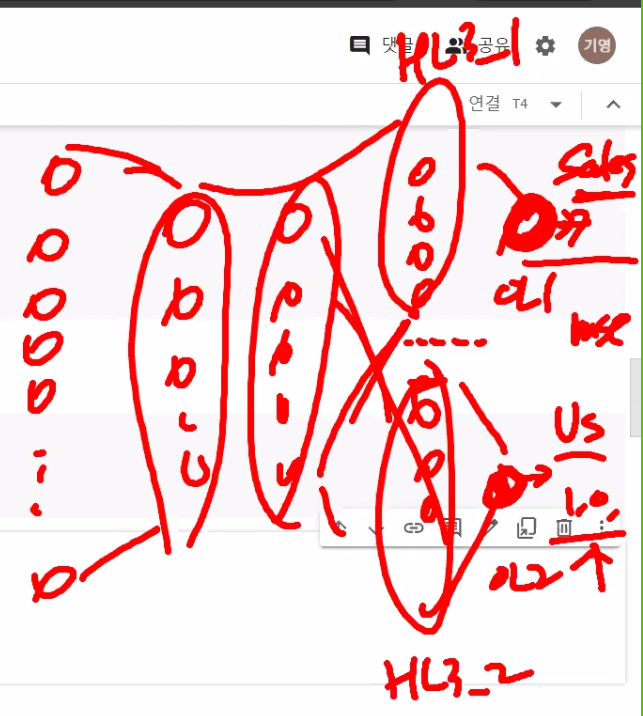

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, Model
from keras.layers import Input, Dense, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam

* 학습곡선 그래프 함수 만들기

In [2]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [3]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(path)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 2.데이터 준비

### (1) 데이터 준비

In [4]:
target1 = 'Sales'
target2 = 'US'

data[target2] = np.where(data[target2] == 'Yes',1,0)

### (2) 가변수화

In [5]:
cat_cols = ['ShelveLoc', 'Education', 'Urban']
data = pd.get_dummies(data, columns = cat_cols, drop_first = True)

### (3) 데이터분할

In [6]:
train, val = train_test_split(data, test_size=.2, random_state = 20)

In [7]:
x_train = train.drop([target1, target2], axis=1)
y_train1 = train.loc[:, target1]
y_train2 = train.loc[:, target2]

x_val = val.drop([target1, target2], axis=1)
y_val1 = val.loc[:, target1]
y_val2 = val.loc[:, target2]

### (4) Scaling

In [8]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
# 각각 fitting하는 순간 train set의 a 데이터와 val set의 a 데이터의 의미는 달라지게 됨

## 3.다중출력
* 아래코드는 예제를 위해 구성한 것입니다.
* 그러나 다중출력은 특별한 목적이 아니라면 권장하지는 않습니다.
* 갈라지기 이전에 loss 여러개를 동시에 낮추는 가중치를 찾아야 하는데, 그 과정이 제대로 이루어질지 의문이므로
* 만약 loss1이 loss2보다 더 클 경우, (scale이 맞지 않을 경우) 모델은 loss1을 줄이는 데 더 치중하므로 각각의 output에 대해 성능이 달라질 수 있음

### (1) 모델 설계

In [9]:
nfeatures = x_train.shape[1]
nfeatures

17

In [11]:
# 입력 레이어 정의
il = Input(shape=(nfeatures,)) # input_shape는 입력 데이터의 형태에 따라 지정

# 은닉 레이어 정의
hl1 = Dense(32, activation='relu')(il)
hl2 = Dense(16, activation='relu')(hl1)

# 첫 번째 출력 레이어 정의
hl3_1 = Dense(4, activation='relu')(hl2)
ol1 = Dense(1, name='output1')(hl3_1) # 회귀

# 두 번째 출력 레이어 정의
hl3_2 = Dense(4, activation='relu')(hl2)
ol2 = Dense(1, activation='sigmoid', name='output2')(hl3_2) # 이진분류

# Model 클래스를 사용하여 모델 정의
model = Model(inputs=il, outputs=[ol1, ol2])

# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 17)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 32)                   576       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 16)                   528       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 4)                    68        ['dense_1[0][0]']             
                                                                                              

### (2) 컴파일 및 학습

In [12]:
# 모델 컴파일
model.compile(optimizer= Adam(0.01),
            #   loss={'output1': 'mse', 'output2': 'binary_crossentropy'}) # 출력층 이름을 기반으로 딕셔너리로 지정
              loss= ['mse', 'binary_crossentropy']) # 출력층 순서대로 리스트로 지정

# 모델 학습
model.fit(x_train, [y_train1, y_train2], epochs=50, validation_split = .2)

Epoch 1/50
8/8 [==============================] - 4s 36ms/step - loss: 58.8484 - output1_loss: 58.1733 - output2_loss: 0.6751 - val_loss: 42.8579 - val_output1_loss: 42.2086 - val_output2_loss: 0.6493
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 29.0404 - output1_loss: 28.4038 - output2_loss: 0.6366 - val_loss: 10.8987 - val_output1_loss: 10.2647 - val_output2_loss: 0.6339
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 12.9659 - output1_loss: 12.3432 - output2_loss: 0.6227 - val_loss: 12.1654 - val_output1_loss: 11.5327 - val_output2_loss: 0.6327
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 9.1932 - output1_loss: 8.5741 - output2_loss: 0.6191 - val_loss: 9.8317 - val_output1_loss: 9.2024 - val_output2_loss: 0.6293
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 7.9899 - output1_loss: 7.3722 - output2_loss: 0.6177 - val_loss: 9.1978 - val_output1_loss: 8.5641 - val_output2_loss: 0.6337
Epoch 6

### (3) 예측 및 평가

In [13]:
# 모델 예측
pred = model.predict(x_val)

3/3 [==============================] - 0s 18ms/step


In [14]:
# 평가1 : sales
pred[0]
print("Sales Prediction:")
print("RMSE :", mean_squared_error(y_val1, pred[0], squared = False))
print("MAE :", mean_absolute_error(y_val1, pred[0]))
print("R2 :", r2_score(y_val1, pred[0]))

Sales Prediction:
RMSE : 1.4431096261805505
MAE : 1.1768962024450302
R2 : 0.7667549403657539


In [15]:
# 평가2 : US
pred2 = np.where(pred[1]>.5, 1,0)
print("US Prediction:")
print(confusion_matrix(y_val2, pred2))
print(classification_report(y_val2, pred2))

US Prediction:
[[28  5]
 [ 8 39]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        33
           1       0.89      0.83      0.86        47

    accuracy                           0.84        80
   macro avg       0.83      0.84      0.83        80
weighted avg       0.84      0.84      0.84        80

